In [53]:
import numpy as np
from numpy.matlib import repmat
import matplotlib.pyplot as plt
from scipy.stats import norm
from math import erf, sqrt
def ncdf(x):
    #'Cumulative distribution function for the standard normal distribution'
    return (1.0 + np.erf(x / np.sqrt(2.0))) / 2.0


In [10]:
def geometric_wiener(Ninit, r, alpha, dt = 0.001, T=1.):
    n = int(T / dt)  
    t = np.linspace(0., T, n) 
    N = np.zeros(n)
    w = wiener_proc(len(t), dt)
    for i in range(0, n):
        N[i] = Ninit*np.exp((r-alpha**2/2)*t[i]+alpha*w[i])
    return t, N

def random_matrix_gen(N_samples):
    mask = np.empty(N_samples)
    for i in range(N_samples[0]):
        mask[i] = np.random.normal(0, 1,N_samples[1]) 
    return mask

def wiener_proc(N_samples, delta):
#     mask = np.empty(N_samples)
#     for i in range(N_samples[1]):
#         mask[:, i] = np.random.normal(0, 1, N_samples[0])
#         mask[0, i] = 0
#         mask[:, i] = mask[:, i].cumsum()*np.sqrt(delta)
    dRW = np.random.normal(0, 1,N_samples)
    dRW[0] = 0
    return np.cumsum(dRW, axis=0)*np.sqrt(delta)

# def barrier(option, strike, s0, n_trials):
class Down_and_out:
    def __init__(self, duration, r, vol, s0, strike, n_trials, n_steps, barrier):
        self.duration = duration
        self.r = r
        self.vol = vol
        self.s0 = s0
        self.strike = strike
        self.n_trials = n_trials
        self.n_steps = n_steps
        self.barrier = barrier
        self.t = np.linspace(0., self.duration, self.n_steps) 
        
    def geometric_wiener(self):
        dt = abs(self.t[1]-self.t[0])
        s = np.zeros(self.n_steps)
        w = wiener_proc(len(t), dt)
        for i in range(0, self.n_steps):
            s[i] = self.s0*np.exp((self.r-self.vol**2/2)*self.t[i]+self.vol*w[i])
        return s
    
#       def geometric_wiener_vectorized(self):
#         dt = abs(self.t[1]-self.t[0])
#         s = np.zeros([self.n_steps, self.n_trials])
#         w = wiener_proc([len(t), self.n_trials], dt)
#         for i in range(0, self.n_steps):
#             s[i, j] = self.s0*np.exp((self.r-self.vol**2/2)*self.t[i]+self.vol*w[i])
#         return s
    
    def simulate(self):
        call_val = 0
        put_val = 0 
        for i in range(0, self.n_trials):
            s = self.geometric_wiener()
            call_val += (s>=self.barrier).prod()*max(0, s[-1]-self.strike)/self.n_trials
            put_val += (s>=self.barrier).prod()*max(0, -s[-1]+self.strike)/self.n_trials
        return call_val, put_val
        
    

In [163]:
barrier_opt = Down_and_out(1, 0.05, 0.25, 50, 40, int(1e5), 1000, 20)

%time barrier_opt.simulate()

AxisError: axis 1 is out of bounds for array of dimension 1

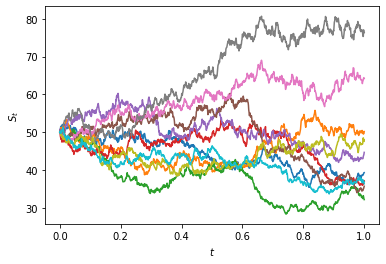

In [11]:
for _ in range(0, 10):
    t, N = geometric_wiener(50, .05, 0.25)
    plt.plot(t, N)
    plt.xlabel(r'$t$')
    plt.ylabel(r'$S_t$')            

In [11]:
def geometric_wiener_vec(w, Ninit, r, alpha, n, T=1.):
    w_shape = np.shape(w)
    t = np.linspace(0., T, n)
#     t = repmat(np.linspace(0., T, n), w_shape[1], 1 )
    N = np.zeros(w_shape)
    for i in range(0, n):
        N[i, :] = Ninit*np.exp((r-alpha**2/2)*t[ i]+alpha*w[i, :])
    return N

In [56]:
1e5

100000.0

In [57]:
norm.rvs(size=[2,1])

array([[0.39626018],
       [1.07217866]])

In [8]:
import time

In [119]:
s0 = 50
r = 0.05
vol  = 0.25
n_samples = 200
n_steps = 20
t = np.linspace(0., 1, n_steps)
dt = t[1]-t[0]
barrier = 20
strike = 40
T=1
def monte_carlo_down_out(T, r, vol, s0, strike, n_steps, n_samples, barrier, method):
    start = time.time()
    price = geometric_wiener_vec(wiener_proc([n_steps, n_samples], T/n_steps), s0, r, vol, n_steps)
    put_price = np.sum((price>=barrier).prod(axis=0)*np.maximum(np.zeros(n_samples),-price[-1, :]+strike))/n_samples
    call_price = np.sum((price>=barrier).prod(axis=0)*np.maximum(np.zeros(n_samples),price[-1, :]-strike))/n_samples
#     call_price_discount = np.array(0)
#     put_price_discount  = np.array(0)
    if method=="continuous":
        call_price_discount = (1-pc(s0, price[-1, :], barrier))*np.maximum(np.zeros(n_samples),price[-1, :]-strike)
        put_price_discount = (1-pc(s0, price[-1, :], barrier))*np.maximum(np.zeros(n_samples),-price[-1, :]+strike) 
    else:
        t = np.linspace(0, T, n_steps)
        call_price_discount = 0
        put_price_discount = 0
        call_price_discount =(pd( s0, price[-1, :], barrier, t))*np.maximum(np.zeros(n_samples),price[-1, :]-strike)
        put_price_discount = (pd( s0, price[-1, :], barrier, t))*np.maximum(np.zeros(n_samples),-price[-1, :]+strike)
    print("European down and out continous barrier option pricing via Monte Carlo simulation")
    print("--------------------------------------------------------------")
    print("Expiration time in years: ", T)
    print("Risk free rate: ",r)
    print("Volatility: ", vol)
    print("Initial price of underlying: ", s0)
    print("Barrier price: ", barrier)
    print("Strike price: ",strike)
    print("Number of trials: ", n_samples)
    print("Number of time steps: ", n_steps)
    print("--------------------------------------------------------------")
    print("Monte Carlo call price: ", call_price)
    print("Monte Carlo put price: ", put_price)
    print("(1-pc) discount call price: ", call_price_discount.mean())
    print("(1-pc) discount put price: ", put_price_discount.mean())
    end = time.time()
    print("Simulation time:", round(end-start, 4), "seconds")

def pc(s0, sT, barrier):
    out = (sT >= barrier)*np.exp(-2*np.log(s0/barrier)*np.log(sT/barrier)/(vol**2*T))
    out = np.where(out==0, 1, out)
    return out

def pd(s0, sT, barrier, t):
    mu = s0+(t*np.ones([len(t),len(sT)]).dot(sT-s0)-t[0])/(t[-1]-t[0])
    var = (t-t[0])*(t[-1]-t)/(t[-1]-t[0])
    mu = mu[1:-2]
    var = var[1:-2]
#     print(1-norm.cdf((barrier-mu)/np.sqrt(var)))
    return (1-norm.cdf((barrier-mu)/np.sqrt(var))).prod(axis=0)
monte_carlo_down_out(T, r, vol, s0, strike, n_steps, n_samples, barrier, "discrete")

European down and out continous barrier option pricing via Monte Carlo simulation
--------------------------------------------------------------
Expiration time in years:  1
Risk free rate:  0.05
Volatility:  0.25
Initial price of underlying:  50
Barrier price:  20
Strike price:  40
Number of trials:  200
Number of time steps:  20
--------------------------------------------------------------
Monte Carlo call price:  12.760331311224286
Monte Carlo put price:  0.6775675392933832
(1-pc) discount call price:  12.760331311224286
(1-pc) discount put price:  0.6775675392933832
Simulation time: 0.012 seconds


In [109]:
np.ones([2,4])*np.linspace(0, 1, 4)*np.linspace(3, 4, 4)

array([[0.        , 1.11111111, 2.44444444, 4.        ],
       [0.        , 1.11111111, 2.44444444, 4.        ]])

In [72]:
def vanilla(s0, strike, r, vol, T):
#     ncdf = normal.cdf
    d1 = (np.log(s0/strike)+T*(r+(1/2)*vol**2))/(vol*np.sqrt(T))
    d2 = (np.log(s0/strike)+T*(r-(1/2)*vol**2))/(vol*np.sqrt(T))
    call = s0*ncdf(d1)-strike*np.exp(-r*T)*ncdf(d2)
    put = strike*np.exp(-r*T)*ncdf(-d2)-s0*ncdf(-d1)
    return call, put

def theoretical_down_out(s0, barrier, strike, r, vol, T):
    call, put = vanilla(s0, strike, r, vol, T)
    cdi, pdi = theoretical_down_in(s0, barrier, strike, r, vol, T)
    return call-cdi, put-pdi

def theoretical_down_in(s0, barrier, strike, r, vol, T):
#     ncdf = normal.cdf
    lam = (r+(vol)**2/2)/vol**2
    x1 = np.log(s0/barrier)/(vol*np.sqrt(T))+lam*vol*np.sqrt(T)
    y1 = np.log(barrier/s0)/(vol*np.sqrt(T))+lam*vol*np.sqrt(T)
    y = np.log(barrier**2/(s0*strike))/(vol*np.sqrt(T))+lam*vol*np.sqrt(T)
    cdi = s0 *ncdf(y)*(barrier/s0)**(2*lam)-strike*np.exp(-r*T)*ncdf(y-vol*np.sqrt(T))*(barrier/s0)**(2*lam-2)
    pdi = -s0 *ncdf(-x1)+strike*np.exp(-r*T)*ncdf(-x1+vol*np.sqrt(T))+s0*(barrier/s0)**(2*lam)*(ncdf(y)-ncdf(y1))-strike*np.exp(-r*T)*(barrier/s0)**(2*lam-2)*(ncdf(y-vol*np.sqrt(T))-ncdf(y1-vol*np.sqrt(T)))
    return cdi, pdi

In [43]:
theoretical_down_out(s0, barrier, strike, r, vol, T)

(12.706255999072322, 0.751889626550769)

In [307]:
def mu(i, sT):
    return s0+(T/n_steps)*i*(sT-s0)/T
def var(i):
    return (T/n_steps)*i*(T-(T/n_steps)*i)/T
arg =1 
for i in range(1, n_steps):
    arg *= 1-norm.cdf((barrier-mu(i, 15)/np.sqrt(var(i))))
print(arg)

1.0


In [2]:
float("1")

1.0

In [46]:
test= np.linspace(0, 5, 1000)
print(test[1]-test[0])
print(5./1000)

0.005005005005005005
0.005
